In [26]:
import datetime
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
import os
from catboost import CatBoostClassifier
from g2net.eda import get_indexed_items, concat_series, merge_iters
from g2net.input import find_files_with_suffix_rooted_at_path, extract_dict_from_df, load_n_samples_with_label
from g2net.pipeline import CkptClassifier, CkptDataLoader
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sktime.transformations.panel.rocket import Rocket

# Preparation

## Global Utilities

In [27]:
DATA_SUFFIX = '.npy'

TRAIN_DATA_DIR = 'data\\train'
TRAIN_BATCH_SIZE = 1024
TRAIN_N_BATCH = 256
TRAIN_LABEL_KEY_COL = 'id'
TRAIN_LABEL_VAL_COL = 'target'
TEST_SAMPLE_SIZE = 64

SUBMIT_DATA_DIR = 'data\\test'

LABEL_COL_NAME = 'class_val'
LABEL_VALUES = [0, 1]

CHANNEL_NAMES = ['channel_1', 'channel_2', 'channel_3']
N_CHANNELS = len(CHANNEL_NAMES)
N_TIMESTEPS = 4096

In [28]:
def raw_dataset_to_df(raw_features, raw_labels):
    raw_features_df = pd.DataFrame(raw_features, columns=CHANNEL_NAMES)
    raw_labels_df = pd.DataFrame(raw_labels, columns=[LABEL_COL_NAME])
    return raw_features_df, raw_labels_df

## Collect File Names

In [29]:
train_file_names = find_files_with_suffix_rooted_at_path(DATA_SUFFIX, TRAIN_DATA_DIR, TRAIN_BATCH_SIZE * TRAIN_N_BATCH + TEST_SAMPLE_SIZE)
train_all_labels_source_df = pd.read_csv('data\\training_labels.csv')
train_all_labels = extract_dict_from_df(train_all_labels_source_df, TRAIN_LABEL_KEY_COL, TRAIN_LABEL_VAL_COL)

KeyboardInterrupt: 

In [ ]:
submit_file_names = find_files_with_suffix_rooted_at_path(DATA_SUFFIX, SUBMIT_DATA_DIR, None)

# EDA

## Constants

In [ ]:
EDA_SAMPLE_SIZE = 1024 * 128
EDA_SAMPLE_TS_COUNT = 1024
EDA_TS_SAMPLE_SIZE = 4

## Loading EDA Data

In [ ]:
eda_raw_features, eda_raw_labels = raw_dataset_to_df(*load_n_samples_with_label(
    train_file_names, 
    train_all_labels, 
    0,
    EDA_SAMPLE_TS_COUNT,
    (N_CHANNELS, N_TIMESTEPS),
))

## Distribution Exploration

First thing that stands out is the fact that the signal strength in some of the examples is very low (~10^-22), so first I would like to get an understanding of the signal strength distribution, i.e. mean/variance. 

In [ ]:
DS_SAMPLE_IDS = random.sample(range(EDA_SAMPLE_TS_COUNT * N_TIMESTEPS * N_CHANNELS), EDA_SAMPLE_SIZE)

In [ ]:
ds_train_timestep_expanded = eda_raw_features.apply(concat_series)
ds_train_channel_expanded = concat_series([ds_train_timestep_expanded[channel] for channel in CHANNEL_NAMES]) * 1e20
ds_train_channels = merge_iters([
    ([channel] * EDA_SAMPLE_TS_COUNT * N_TIMESTEPS) 
    for channel in CHANNEL_NAMES
])
desc_stats_features_map = {
    'data': get_indexed_items(ds_train_channel_expanded, DS_SAMPLE_IDS),
    'channel': get_indexed_items(ds_train_channels, DS_SAMPLE_IDS)
}

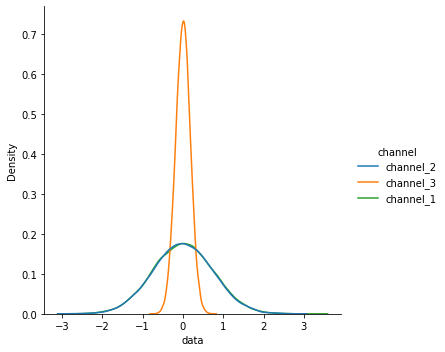

In [ ]:
sns.displot(desc_stats_features_map, x='data', hue='channel', kind='kde')

Next it's beneficial to get a feeling of the label landscape.

In [ ]:
eda_raw_labels[LABEL_COL_NAME].value_counts()

1    514
0    510
Name: class_val, dtype: int64

## Time Variance

Then we would like to take a look at the time variance of the different channels for a few 0/1 signals.

In [ ]:
ds_ts_samples = [
    eda_raw_features[eda_raw_labels[LABEL_COL_NAME] == label_value].sample(n=EDA_TS_SAMPLE_SIZE) * 1e20 
    for label_value in LABEL_VALUES
]

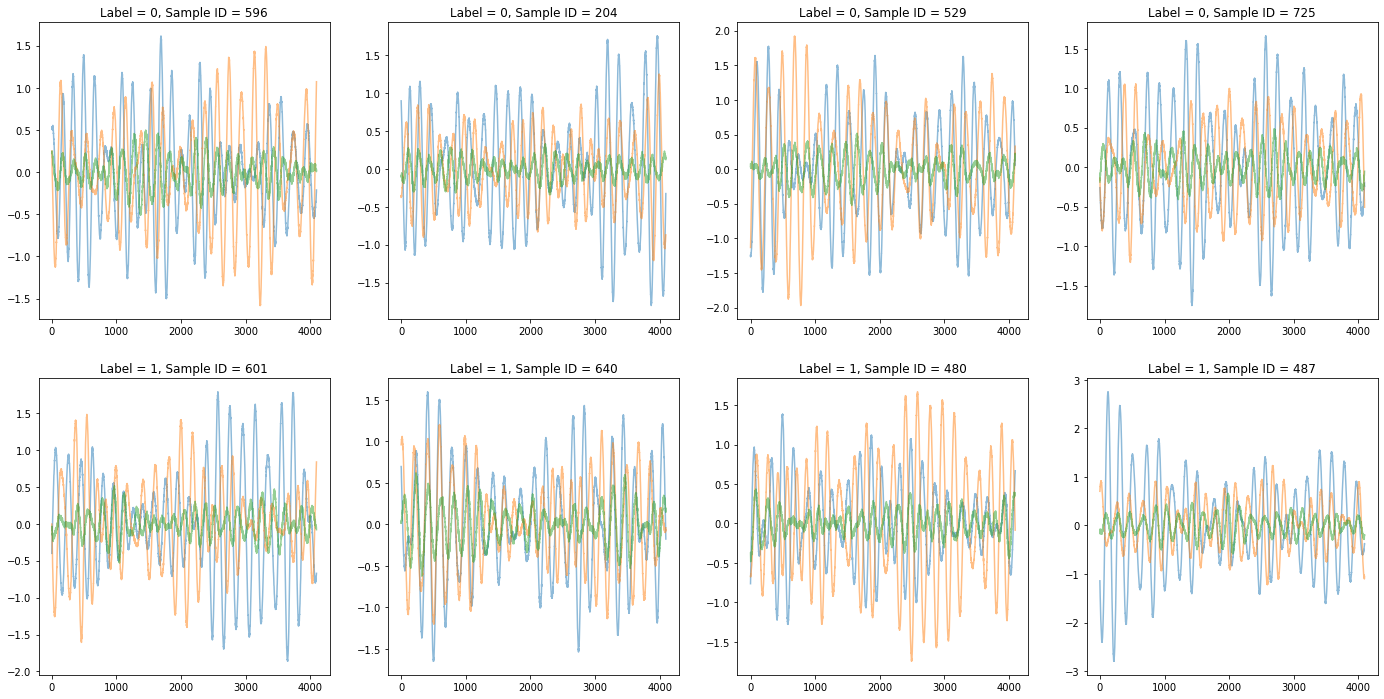

In [ ]:
fig, ax = plt.subplots(len(LABEL_VALUES), EDA_TS_SAMPLE_SIZE, figsize=(24, 12))
for label_value in LABEL_VALUES:
    for sample_id in range(EDA_TS_SAMPLE_SIZE):
        for c_id in range(N_CHANNELS):
            sns.lineplot(
                data=ds_ts_samples[label_value].iloc[sample_id, c_id], 
                alpha=0.5, 
                ax=ax[label_value][sample_id]
            ).set_title(f'Label = {label_value}, Sample ID = {ds_ts_samples[label_value].index[sample_id]}')

# Model Selection

## Preprocessing

Here we summarise what we have learned in the EDA step, and apply transformations on our input data accordingly.
Overall the dataset looks pretty clean, so we simply scale the signals up to the 10^0 magnitude.

In [ ]:
def scale_pd_series(series: pd.Series) -> pd.Series:
    scaler = StandardScaler()
    reshaped_series = series.to_numpy().reshape(-1, 1)
    scaled_series = scaler.fit_transform(reshaped_series).reshape(-1)
    return pd.Series(scaled_series)

In [ ]:
def preprocess(raw_features, raw_labels):
    return raw_features.applymap(scale_pd_series), raw_labels

## Prepare Testing Dataset

In [ ]:
test_raw_features, test_labels = preprocess(*raw_dataset_to_df(*load_n_samples_with_label(
    train_file_names, 
    train_all_labels, 
    TRAIN_BATCH_SIZE * TRAIN_N_BATCH,
    TEST_SAMPLE_SIZE,
    (N_CHANNELS, N_TIMESTEPS),
)))

## Model Definitions

In [ ]:
# Create an iterable dataset for the training data
train_raw_batches = lambda n_batch, ckpt_path=None: CkptDataLoader(
    train_file_names, 
    train_all_labels, 
    n_batch, 
    TRAIN_BATCH_SIZE, 
    (N_CHANNELS, N_TIMESTEPS),
    ckpt_path
)

### ROCKET

ROCKET transforms time series using random convolutional kernels (random length, weights, bias, dilation, and padding). ROCKET computes two features from the resulting feature maps: the max, and the proportion of positive values (or ppv). 

In [ ]:
# Constants
N_ROCKET_FIT_BATCH = 8

In [ ]:
# Model Initialisation
rocket = Rocket(num_kernels=100)

### Classifiers

In [ ]:
CKPT_PATH = 'checkpoints\\'

Linear Classifier

In [ ]:
linear_ckpt_classifier = CkptClassifier(
    RidgeClassifierCV, 
    ckpt_path=os.path.join(CKPT_PATH, 'ridge.joblib'), 
    alphas=np.logspace(-3, 3, 10), 
    normalize=True
)

Neural Network

In [ ]:
nn_classifier = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2)
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
nn_classifier.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
cp_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=os.path.join(CKPT_PATH, 'nn.ckpt'), save_weights_only=True, verbose=0
)

Gradient Boosting Machine

In [ ]:
gbm_ckpt_classifier = CkptClassifier(
    CatBoostClassifier, 
    ckpt_path=os.path.join(CKPT_PATH, 'gbm.joblib')
)

## Model Fitting

In [ ]:
# Fit the ROCKET transformer
for batch in train_raw_batches(N_ROCKET_FIT_BATCH):
     train_features, _ = preprocess(*raw_dataset_to_df(*batch))
     rocket.fit(train_features)

In [36]:
# Transform the input and fit the classifiers
with linear_ckpt_classifier as linear_classifier:
    with gbm_ckpt_classifier as gbm_classifier:
        with train_raw_batches(TRAIN_N_BATCH, os.path.join(CKPT_PATH, 'data_loader.joblib')) as train_data:
            for batch_id, batch in enumerate(train_data):
                train_features, train_labels = preprocess(*raw_dataset_to_df(*batch))
                train_trans_features = rocket.transform(train_features)

                linear_classifier.fit(train_trans_features, train_labels.to_numpy().reshape(-1))
                nn_classifier.fit(train_trans_features, train_labels, epochs=32, verbose=0, callbacks=[cp_callback])
                gbm_classifier.fit(train_trans_features, train_labels, verbose=False)
                
                print(f'Label Mean = {train_labels.mean()}')
                lin_pred = linear_classifier.predict(train_trans_features)
                print(f'Linear Predictions Mean = {np.mean(lin_pred)}')

                print(f'Accuracy on training set: Linear = {linear_classifier.score(train_trans_features, train_labels)}, '
                                                f'NN = {nn_classifier.evaluate(train_trans_features, train_labels)[1]}, '
                                                f'GBM = {gbm_classifier.score(train_trans_features, train_labels)}')
                
                print(f'[{datetime.datetime.now().strftime("%H:%M:%S")}] Finished running training batch {batch_id}')

Label Mean = class_val    0.506836
dtype: float64
Linear Predictions Mean = 1.0
32/32 [==============================] - 0s 839us/step - loss: 0.6895 - accuracy: 0.5381
Accuracy on training set: Linear = 0.5068359375, NN = 0.5380859375, GBM = 1.0
[15:04:54] Finished running training batch 0
Label Mean = class_val    0.511719
dtype: float64
Linear Predictions Mean = 1.0
32/32 [==============================] - 0s 1000us/step - loss: 0.6928 - accuracy: 0.5127
Accuracy on training set: Linear = 0.51171875, NN = 0.5126953125, GBM = 1.0
[15:05:56] Finished running training batch 1


KeyboardInterrupt: 

## Model Testing

In [ ]:
test_trans_features = rocket.transform(test_raw_features)

In [ ]:
linear_ckpt_classifier.classifier.score(test_trans_features, test_labels)

In [ ]:
nn_classifier.evaluate(test_trans_features, test_labels)

In [ ]:
gbm_classifier.classifier.score(test_trans_features, test_labels)